# Grafy dotyczące EDA

### Importy bibliotek

In [31]:
from datetime import datetime
from copy import deepcopy

import pandas as pd
import numpy as np

import seaborn as sns; sns.set()
import matplotlib.pylab as plt

### Zczytanie danych z plików csv

* Pliki znajdują sie w folderze data i mają nazwy
    * PPK_Uczestnicy.csv
    * PPK_Pracodawcy.csv
* Po zczytaniu operacja merge złaczamy dane tak, że informacja o pracodawcy jest dostepna z poziomu pracownika

In [32]:
# Pliki CSV umieszczone w folderze data
uczestnicy = pd.read_csv('data/PPK_Uczestnicy.csv', sep=';')
pracodawcy = pd.read_csv('data/PPK_Pracodawcy.csv',sep=';')

# Mergowanie dwóch csv
df = pd.merge(
    uczestnicy,
    pracodawcy,
    how='left',
    left_on='EMPL_ID',
    right_on='ID'
)

### Przerobienie danych na bardziej przystępne

* Zmiana kolumny `AGE` na typ int
* Podzial wieku na przedzialy \[30,40), [40,50) ...
* Drop'owanie niepotrzebnych kolumn
* Znaleznie kolumny `Duration` oznaczajacej ilosc dni kiedy od poczatku bycia w PPK do dnia `RESIGN_DATE` lub do dnia dzisiejszego

In [33]:
#Age to int
def to_int(age):
    age = age[:age.find(",")]
    return int(age)
df["AGE"] = df["AGE"].apply(to_int)

#dziele na pudelka z [30,40) itp
def to_box(age):
    return (age//10) * 10
df["AGE_BOX"] = df["AGE"].apply(to_box)

# Dropowanie niepotrzebnych kolumn
df.drop(columns=['MEMBER_ID','EMPL_ID', 'WORK_START', 'WORK_STOP', 'LOGICAL_FACTOR_1','LOGICAL_FACTOR_2','ID','PKD_CODE','PPK_BANK','NUMERICAL_VALUE'], inplace=True)


# find duration of sign itp
def find_period(data):
    start, stop = data
    if type(stop) is float:
        return None
    
    start_year, start_month, start_day = map(int, start.split('-'))
    stop_year, stop_month, stop_day = map(int, stop.split('-'))
    
    days = (stop_year - start_year)*365
    days += (stop_month - start_month)*30 if stop_month > start_month else (start_month - stop_month)*30
    days += stop_day - start_day if stop_day > start_day else start_day - stop_day
    
    return days


df['DURATION'] = list(zip(df['CREATED_AT'], df['RESIGN_DATE']))

df['DURATION'] = df['DURATION'].apply(find_period) 

### Przerobienie narodowości 

przy zalozeniu ze narodowosci z populacja ponizej 5000 łączymy w jedną kategorię

In [34]:
# Grouping other nationalities into one category '0'
unique_nat = df['NATIONALITY'].unique()
# For all with population lower than 1000 we merge them in one category 
for val in unique_nat:
    suma = ( df['NATIONALITY'].values == val ).sum()
    if suma < 1000:
        df.loc[df.NATIONALITY == val, 'NATIONALITY'] = 0

### Stworzenie grafów zależności odejścia od zmiennej

Jest to ilość osób które odeszły / ilośc osób należących do danej kategorii

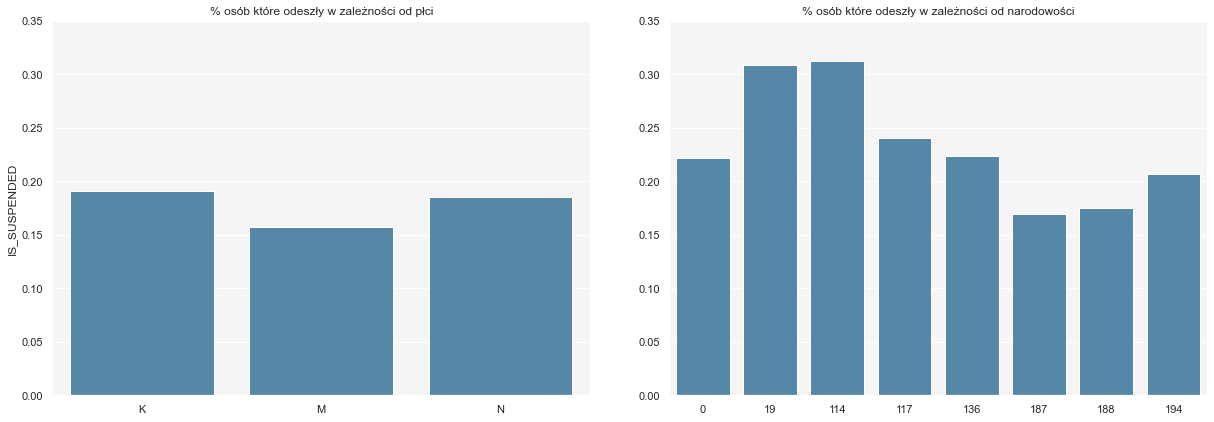

In [35]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,7))

sns.barplot(x = df['SEX'], y = df['IS_SUSPENDED'], color='#488ab5', ci=None, ax=ax[0], order=["K","M","N"])
ax[0].set_facecolor('#f5f5f5')
ax[0].set_xlabel(None)
ax[0].set_ylim(0,0.35)
ax[0].set_title('% osób które odeszły w zależności od płci')

sns.barplot(x = df['NATIONALITY'], y = df['IS_SUSPENDED'], color='#488ab5', ci=None, ax=ax[1])
ax[1].set_facecolor('#f5f5f5')
ax[1].set_ylabel(None)
ax[1].set_ylim(0,0.35)
ax[1].set_xlabel(None)
ax[1].set_title('% osób które odeszły w zależności od narodowości')

plt.tight_layout(pad=4.0)

Text(0.5, 1.0, '% osób które odeszły w zależności od wojewodztwa')

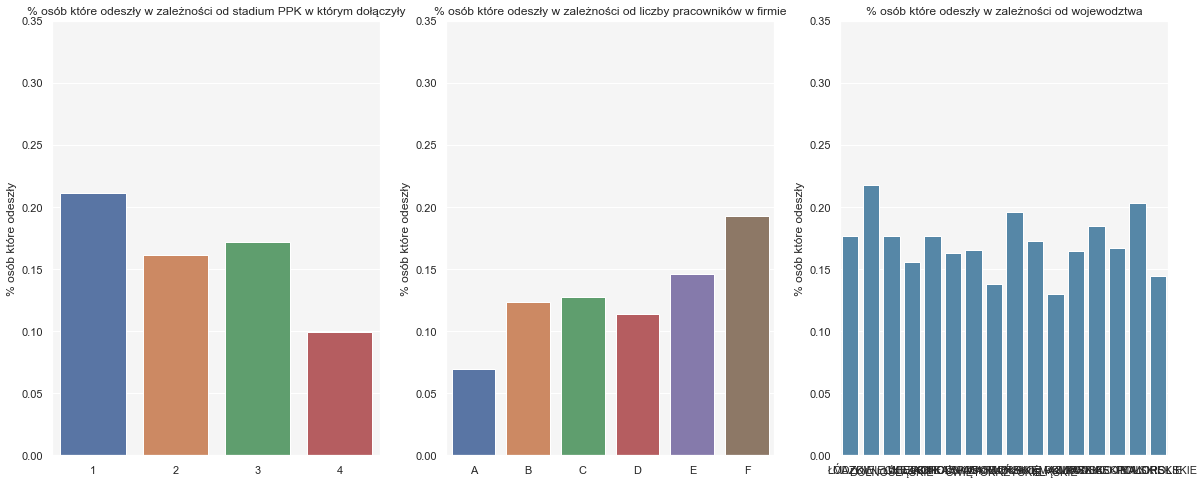

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,8))

sns.barplot(x = df['PPK_STAGE'], y = df['IS_SUSPENDED'], ci=None, ax=ax[0])
ax[0].set_facecolor('#f5f5f5')
ax[0].set_xlabel(None)
ax[0].set_ylim(0,0.35)
ax[0].set_ylabel("% osób które odeszły")
ax[0].set_title('% osób które odeszły w zależności od stadium PPK w którym dołączyły')


sns.barplot(x = df['COMPANY_SIZE'], y = df['IS_SUSPENDED'], ci=None, ax=ax[1], order=["A","B","C","D","E","F"])
ax[1].set_facecolor('#f5f5f5')
ax[1].set_xlabel(None)
ax[1].set_ylabel("% osób które odeszły")
ax[1].set_ylim(0,0.35)
ax[1].set_title('% osób które odeszły w zależności od liczby pracowników w firmie')


sns.barplot(x = df['VOIVODESHIP'], y = df['IS_SUSPENDED'], color='#488ab5', ci=None, ax=ax[2])
ax[2].set_facecolor('#f5f5f5')
ax[2].set_xlabel(None)
ax[2].set_ylabel("% osób które odeszły")
ax[2].set_ylim(0,0.35)
ax[2].set_title('% osób które odeszły w zależności od wojewodztwa')


Text(0.5, 1.0, 'Zależność odejścia osób z programu zależnie od wieku')

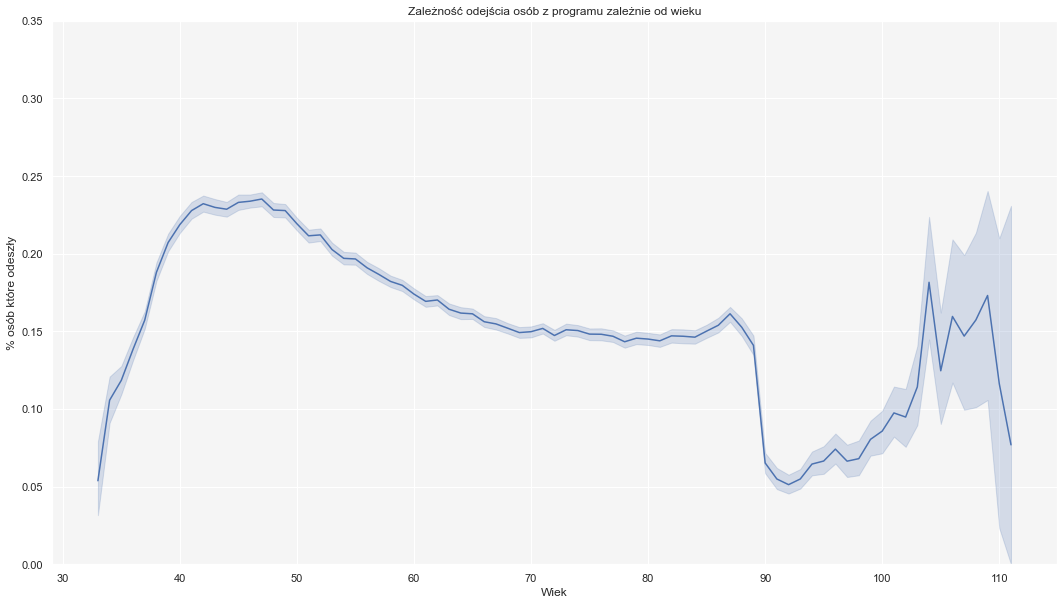

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,10))
sns.lineplot(x = df['AGE'], y = df['IS_SUSPENDED'],ax=ax)
ax.set_facecolor('#f5f5f5')
ax.set_ylim(0,0.35)
ax.set_ylabel("% osób które odeszły")
ax.set_xlabel("Wiek")
ax.set_title('Zależność odejścia osób z programu zależnie od wieku')

Text(0.5, 1.0, 'Wpłata powitalna')

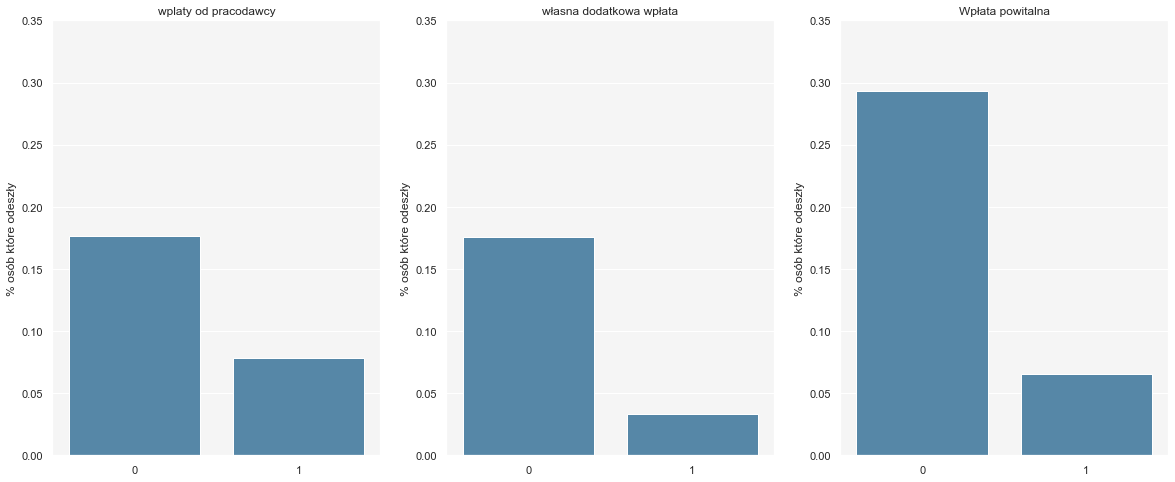

In [38]:
fig, ax = plt.subplots(ncols=3, figsize=(20,8))

# HAS\_AE - Czy pracownik otrzymuje wpłatę dodatkową od pracodawcy?
sns.barplot(x = df['HAS_AE'], y = df['IS_SUSPENDED'], color='#488ab5', ci=None, ax=ax[0])
ax[0].set_facecolor('#f5f5f5')
ax[0].set_xlabel(None)
ax[0].set_ylabel("% osób które odeszły")
ax[0].set_ylim(0,0.35)
ax[0].set_title('wplaty od pracodawcy')

# HAS\_AW - Czy pracownik wpłaca własną dodatkową wpłatę?
sns.barplot(x = df['HAS_AW'], y = df['IS_SUSPENDED'], color='#488ab5', ci=None, ax=ax[1])
ax[1].set_facecolor('#f5f5f5')
ax[1].set_xlabel(None)
ax[1].set_ylabel("% osób które odeszły")
ax[1].set_ylim(0,0.35)
ax[1].set_title('własna dodatkowa wpłata')

# HAS\_IP - Czy pracownik otrzymał wpłatę powitalną?
sns.barplot(x = df['HAS_IP'], y = df['IS_SUSPENDED'], color='#488ab5', ci=None, ax=ax[2])
ax[2].set_facecolor('#f5f5f5')
ax[2].set_xlabel(None)
ax[2].set_ylabel("% osób które odeszły")
ax[2].set_ylim(0,0.35)
ax[2].set_title('Wpłata powitalna')

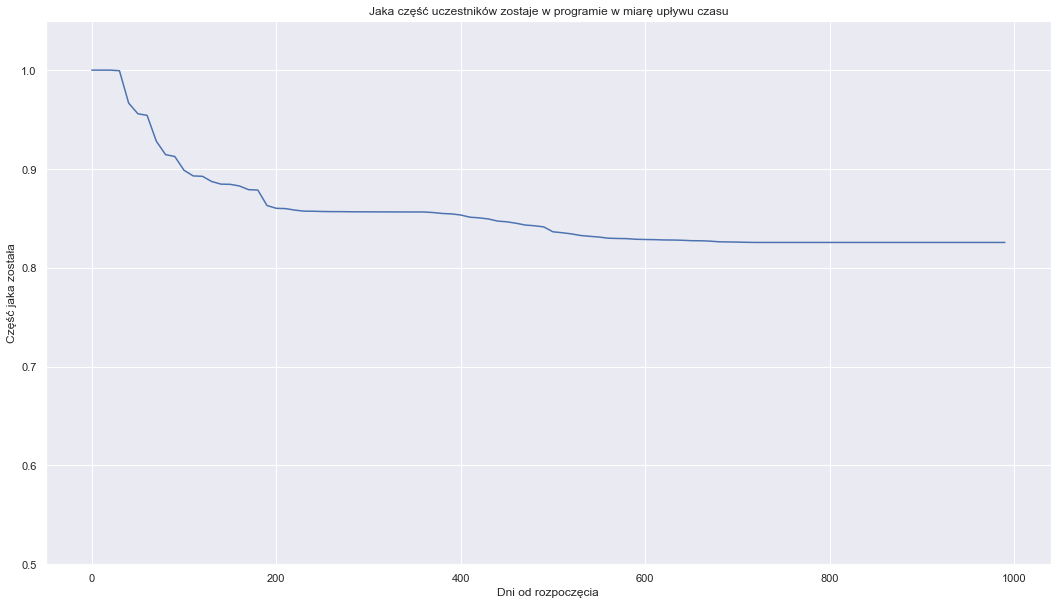

In [39]:
out = []

for i in range(0, 1000, 10):
    out.append(1-df[df["DURATION"]<i]["IS_SUSPENDED"].sum()/len(df))
    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,10))
ax.plot(np.arange(0,1000,10), out)

ax.set(xlabel='Dni od rozpoczęcia', ylabel='Część jaka została',
       title='Jaka część uczestników zostaje w programie w miarę upływu czasu')
plt.ylim(0.5, 1.05)

plt.show()